# Coding assignment: reaction-diffusion and Gray Scott model 

In [14]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

# Modèle

Le modèle de Gray-Scott représente la réaction et la diffusion de deux espèces chimiques génériques $U$ et $V$ dont les concentrations en un point de l'espace sont représentées par les variables $u$ et $v$. Il suit quelques règles simples:


* Le taux d'alimentation en particules $U$ du système est constant.
* Si deux particules $V$ rencontrent une particule $U$, elles convertissent cette dernière en particule $V$.
* Un taux d'annihilation constant retire les particules $v$ du système.

Les équations différentielles partielles de Gray-Scott sont données par: 

\begin{align}
\frac{\partial u}{\partial t} &= D_u \nabla ^2 u - uv^2 + F(1-u)\\
\frac{\partial v}{\partial t} &= D_v \nabla ^2 v + uv^2 - (F + k)v
\end{align}


Le premier terme des deux équations correspond à la diffusion spatiale de chaque concentration, où $D_u$ et $D_v$ sont les taux de diffusion de $u$ et $v$ respectivement. Le deuxième terme donne quant à lui la réaction et le terme final le taux de d'alimentation pour $u$ dans la première équation et le taux d'annihilation pour $v$ dans la seconde. 

# Position du problème

On considère un domaine défini par: 


* une grille de points de dimension $192x192$
* le domaine est de dimension $5mx5m$
* un temps final de $8000s$

Nous allons discrétiser les équations de Gray-Scott en utilisant une _forward difference_ pour le temps et une _central difference_ pour l'espace en considérant $\Delta x = \Delta y = \delta$. Nous prendons $$\Delta t = \frac{9}{40}\frac{\delta^2}{\max(D_u, D_v)}$$ 

comme étape temporelle. Cette valeur assure une certaine stabilité d'après la condition CFL. En effet, dans le cas  $\Delta x = \Delta y = \delta$, cette dernière est donnée par: 

\begin{equation}
\alpha \frac{\Delta t}{\delta^2} < \frac{1}{4}
\end{equation}

où $\alpha$ est le coefficient devant les dérivées secondes dans les équations différentielles que nous considérons et correspond donc à $D_u$ et $D_v$. Cette condition devant être valable pour les deux équations, il nous faut prendre la plus restrictive, ce qui équivaut à prendre $\alpha=\max(D_u, D_v)$.

Nous utiliserons une condition aux limites de Neumann (égale à zéro) sur toutes les frontières du domaine. Rappelons qu'une condition aux limites de Neumann spécifie la valeur de la dérivée de la solution au bord plutôt que la valeur de la solution au bord. Par conséquent, les valeurs au bord du tableau seront égales à leurs voisines.

# Résolution

Commençons par discrétiser nos équations: 

\begin{equation}
\frac{u^{n+1}_i-u^n_i}{\Delta t}=D_u \frac{u^n_{i+1}-2u^n_i+u^n_{i-1}}{\delta^2} - u^n_i(v^n_i)^2 + F(1-u^n_i)
\end{equation}
\begin{equation}
\frac{v^{n+1}_i-v^n_i}{\Delta t}=D_v \frac{v^n_{i+1}-2v^n_i+v^n_{i-1}}{\delta^2} + u^n_i(v^n_i)^2 - (F+k)v^n_i
\end{equation}

Et donc, 

\begin{equation}
u^{n+1}_i=u^n_i+\Delta t\left(D_u \frac{u^n_{i+1}-2u^n_i+u^n_{i-1}}{\delta^2} - u^n_i(v^n_i)^2 + F(1-u^n_i)\right)
\end{equation}

\begin{equation}
v^{n+1}_i=v^n_i+\Delta t\left(D_v \frac{v^n_{i+1}-2v^n_i+v^n_{i-1}}{\delta^2} + u^n_i(v^n_i)^2 - (F+k)v^n_i\right)
\end{equation}

Posons nos conditions initiales.

In [20]:
n = 192
Du, Dv, F, k = 0.00016, 0.00008, 0.035, 0.065 # Bacteria 1 
dh = 5./(n-1)
T = 8000
dt = .9 * dh**2 / (4*max(Du,Dv))
nt = int(T/dt)

uvinitial = numpy.load('./data/uvinitial.npz')
winitial=numpy.ones((2,n,n))
winitial[0] = uvinitial['U'] #première composante: u=concentration de l'espèce U
winitial[1] = uvinitial['V'] #deuxième composante: v=concentration de l'espèce V

Il nous faut à présent écrire quelques fonctions:


* Une première pour calculer le laplacien de nos deux concentrations.
* Une deuxième pour implémenter les discrétisations des dérivées des concentrations.
* Une troisième pour calculer leur évolution. 

Notons que les concentrations sont contenues dans un tableau $w$ et que c'est donc sur ce dernier que l'on effectue en pratique les opérations susmentionnées. 

In [21]:
def lapl(w,dh):
    return (w[2:,1:-1]-2*w[1:-1,1:-1]+w[:-2,1:-1]+w[1:-1,2:]-2*w[1:-1,1:-1]+w[1:-1,:-2])/dh**2

In [22]:
def wpoint(w,Du,Dv,F,k,dh):
    return numpy.array([Du*lapl(w[0],dh)-w[0,1:-1,1:-1]*(w[1,1:-1,1:-1])**2+F*(1-w[0,1:-1,1:-1]),
                       Dv*lapl(w[1],dh)+w[0,1:-1,1:-1]*w[1,1:-1,1:-1]**2-(F+k)*w[1,1:-1,1:-1]])

In [23]:
def grayscott(winitial,Du,Dv,F,k,dh,nt,dt):
    w=winitial.copy()
    for t in range(nt):
        wn=w.copy()
        w[:,1:-1,1:-1]=wn[:,1:-1,1:-1]+dt*wpoint(wn,Du,Dv,F,k,dh)
        
        #Conditions aux limites de Neumann
        w[:,:,-1]=w[:,:,-2]
        w[:,-1,:]=w[:,-2,:]
        w[:,0,:]=w[:,1,:]
        w[:,:,0]=w[:,:,1]
    return w

# Résultats 

Appelons notre fonction Grayscott et calculons les résultats pour $t_{final}=8000s$ c'est à dire à la dernière étape de notre simulation. 

In [24]:
w=grayscott(winitial,Du,Dv,F,k,dh,nt,dt)

In [25]:
w[0,100,::40]

array([ 0.92469521,  0.85013834,  0.66815621,  0.90196481,  0.9039502 ])

Les 5 valeurs du tableau correspondent à 5 valeurs de u (qui est, rappelons-le, la concentration en espèce U), chacune d'entre elles étant prises à des endroits différents dans le tableau.

On voit que la concentration u n'est pas constante dans l'espace. 

Illustrons les résultats de réaction-diffusion de l'espèce U et de l'espèce V:  

In [26]:
x = numpy.linspace(0,5,n)
y = numpy.linspace(0,5,n)
mx, my = numpy.meshgrid(x,y)

Graphique pour la concentration de l'espèce U dans l'espace:

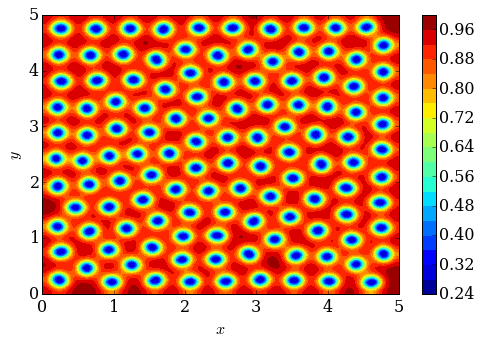

In [27]:
pyplot.figure(figsize=(8,5))
pyplot.contourf(mx,my,w[0,:,:],20)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

Graphique pour la concentration de l'espèce V dans l'espace:

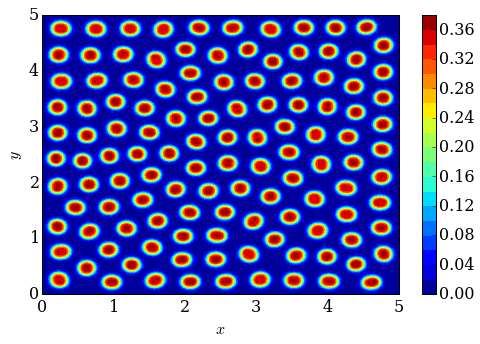

In [28]:
pyplot.figure(figsize=(8,5))
pyplot.contourf(mx,my,w[1,:,:],20)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

On voit que la concentration en V est plus élevée en de petites zones de mêmes tailles et équidistantes, en ces endroits la concentration en U est faible. Dans l'espace qui sépare ces zones, la concentration en U est plus grande. 